In [1]:
import sys, importlib, time
sys.path.append('../../')
#sys.path.append('../../src/')

from src.Modules.Utils.Imports import *
from src.Modules.Models.BuildBINNs import BINN
from src.Modules.Utils.ModelWrapper import ModelWrapper
from src.Modules.Utils.Gradient import Gradient

import src.Modules.Utils.PDESolver as PDESolver
import src.Modules.Loaders.DataFormatter as DF

from src.DE_simulation import fickian_diffusion, Diffusion_eqn, simple_pulling_diffusion, simple_adhesion_diffusion
from scipy.integrate import odeint

device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

def initialize_param_plot():
    
    fig = plt.figure(figsize=(3.75*2,4*1))

    ylabels = [r'Diffusivity (mm$^2$/wk)', r'Growth (1/wk)']
    xlabels = ['Cell density (Normalized)','Cell density (Normalized)']
    titles = [r'$D$', r'$G$']
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    axs = [ax1,ax2]

    fontsize=15

    #iterate through axes and set xlabel, ylabel, title
    for ax, ylabel, xlabel, title in zip(axs, ylabels,xlabels, titles):
        ax.set_ylabel(ylabel,fontsize=fontsize)
        ax.set_xlabel(xlabel,fontsize=fontsize)
        ax.set_title(title,fontsize=fontsize)
    for ax in axs:
        ax.grid()
        
    return fig, axs

def load_model(binn_name, x, t, save_name):

    # instantiate BINN
    binn = BINN(binn_name,x, t).to(device)

    # wrap model and load weights
    parameters = binn.parameters()
    model = ModelWrapper(
        model=binn,
        optimizer=None,
        loss=None,
        save_name=save_name)
    
    #model.save_name += '_' + binn.name + weight
    model.save_name += weight
    model.load(model.save_name + '_model', device=device)

    return model, binn


def recover_binn_params(binn):
    # learned diffusion term
    def D(u):
        D = binn.diffusion(to_torch(u)[:, None])
        return to_numpy(D).reshape(-1)

    # learned growth term
    def G(u):
        r = binn.growth(to_torch(u)[:, None])
        return to_numpy(r).reshape(-1)  

    return D, G

Device set to cuda:0


## Pulling

In [14]:
### Data information
path = '../../data/'

scenario = "Pulling_vary_Ppull"
if scenario == "Pulling_vary_Ppull":
    Ppulls = np.round(np.linspace(0.0,1.0,11),2)[:,None]
    Pms = np.round(1.0*np.ones((11,)),2)[:,None]
    Pps = np.round(np.zeros((11,)),2)[:,None]
    params = np.hstack([Pms,Pps,Ppulls])
    diffusion = simple_pulling_diffusion
    filename_header = "simple_pulling_mean_25"
    suptitle = "Ppull"
elif scenario == "Pulling_vary_Pm":
    Ppulls = np.round(.5*np.ones((10,)),2)[:,None]
    Pms = np.round(np.linspace(0.1,1.0,10),2)[:,None]
    Pps = np.round(np.zeros((10,)),2)[:,None]
    params = np.hstack([Pms,Pps,Ppulls])
    diffusion = simple_pulling_diffusion
    filename_header = "simple_pulling_mean_25"
    suptitle = "Pm"
elif scenario == "Adhesion_vary_Padh":
    Padhs = np.round(np.linspace(0.0,1.0,11),2)[:,None]
    Pms = np.round(1.0*np.ones((11,)),2)[:,None]
    Pps = np.round(np.zeros((11,)),2)[:,None]
    params = np.hstack([Pms,Pps,Padhs])
    diffusion = simple_adhesion_diffusion    
    filename_header = "simple_adhesion_mean_25"
    suptitle = "Padh"
elif scenario == "Adhesion_vary_Pm":
    Padhs = np.round(0.5*np.ones((10,)),2)[:,None]
    Pms = np.round(np.linspace(0.1,1.0,10),2)[:,None]
    Pps = np.round(np.zeros((10,)),2)[:,None]
    params = np.hstack([Pms,Pps,Padhs])
    diffusion = simple_adhesion_diffusion        
    filename_header = "simple_adhesion_mean_25"
    suptitle = "Pm"    

    
#vary Pm

### BINN model information
save_folder = "../../Weights/"
model_name = 'DMLP'
weight = '_best_val'
surface_weight = 1.0
pde_weight = 1e4

models = []
binns = []
inputs_list = []
outputs_list = []

for Pm, Pp, Pinteraction in params:
    
    if "Pulling" in scenario:
        file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Ppull_{Pinteraction}'
    elif "Adhesion" in scenario:
        file_name = f'{filename_header}_Pm_{Pm}_Pp_{Pp}_Padh_{ Pinteraction}'    

    ### load in data
    inputs, outputs, shape  = DF.load_ABM_data(path+file_name+".npy",plot=False)
    x = inputs[:,0]
    t = inputs[:,1]
    binn_name  = f"{model_name}"
    save_name =  f"BINN_training_{binn_name}_{file_name}_pde_weight_{pde_weight}"
    #save_name =  f"BINN_training_{binn_name}_{file_name}"
    model,binn = load_model(binn_name=binn_name,save_name=save_folder + save_name,x=x,t=t)

    models.append(model)
    binns.append(binn)
    inputs_list.append(inputs)
    outputs_list.append(outputs)


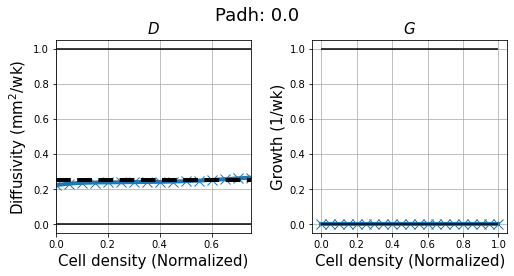

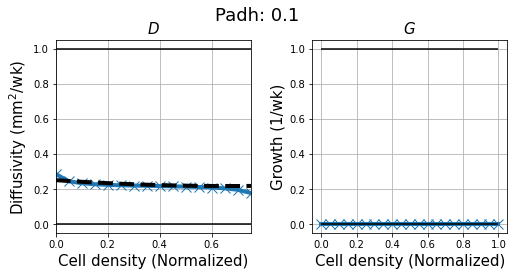

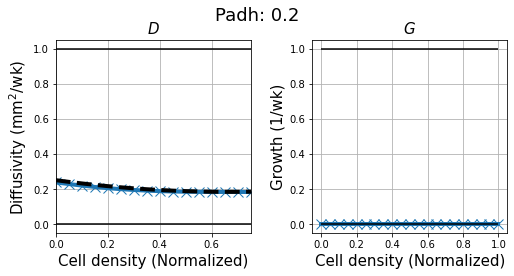

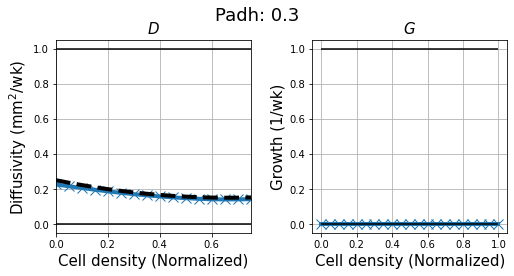

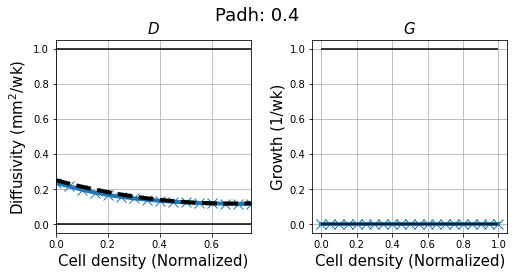

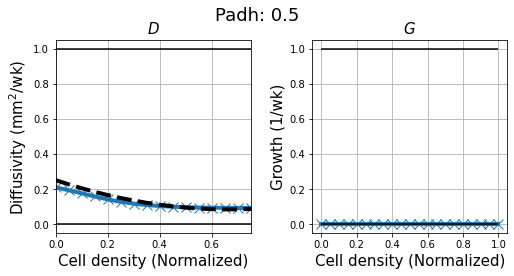

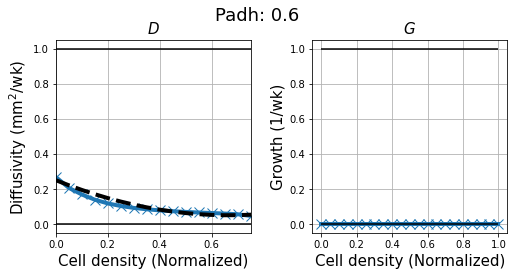

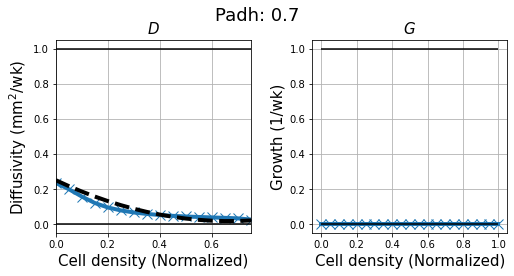

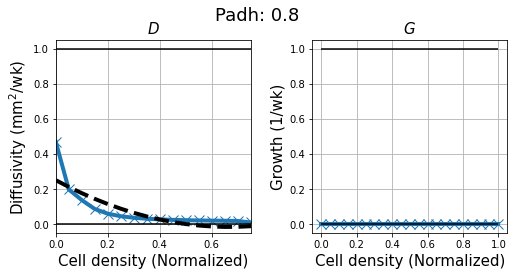

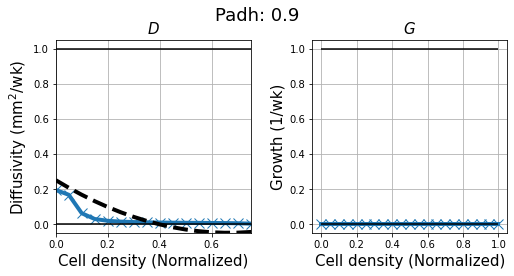

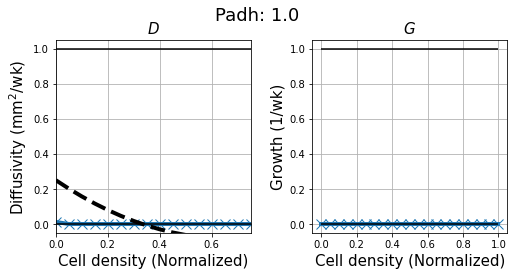

In [15]:
#initialize plot

fontsize=18

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['x','o','s','^','*','d']
colors_plot = colors[:11]
markers_plot = markers[:5]
marker = markers_plot[0]
color = colors_plot[0]

# create meshes
u_mesh = np.linspace(0, 1, 21)

###### plot
for binn, param_combo in zip(binns,params):
    
    Pm, Pp, Pinteraction = param_combo

    fig, axs = initialize_param_plot()
    
    # evaluate parameter networks
    D_mesh = to_numpy(binn.diffusion(to_torch(u_mesh)[:, None]))
    G_mesh = to_numpy(binn.growth(to_torch(u_mesh)[:, None]))
    param_meshes = [D_mesh, G_mesh]

    for ax, param_mesh in zip(axs,param_meshes):
        ax.plot(u_mesh, param_mesh, '-' + marker, color=color,linewidth=4,markersize=10)

    axs[0].plot(u_mesh, diffusion(u_mesh,[Pm/4,Pinteraction]),"k--",linewidth=4)
        
    # minimum and maximum D/G values
    dmin = binn.D_min
    dmax = binn.D_max
    gmin = binn.G_min
    gmax = binn.G_max

    param_lims = [ [dmin,dmax], [gmin,gmax]]    
    for ax, param_mesh, param_lim in zip(axs,param_meshes, param_lims):    
        ax.hlines(param_lim,xmin=np.min(u_mesh),xmax=np.max(u_mesh),colors="k")

    axs[0].set_xlim([0,0.75])
    axs[0].set_ylim([-0.05,1.05])
    plt.tight_layout(pad=2)
    plt.suptitle(f"{suptitle}: {Pinteraction}",fontsize=fontsize)
    #plt.savefig(f'../Figures/onespecies_learned_params_{cell_line}.pdf', format='pdf')

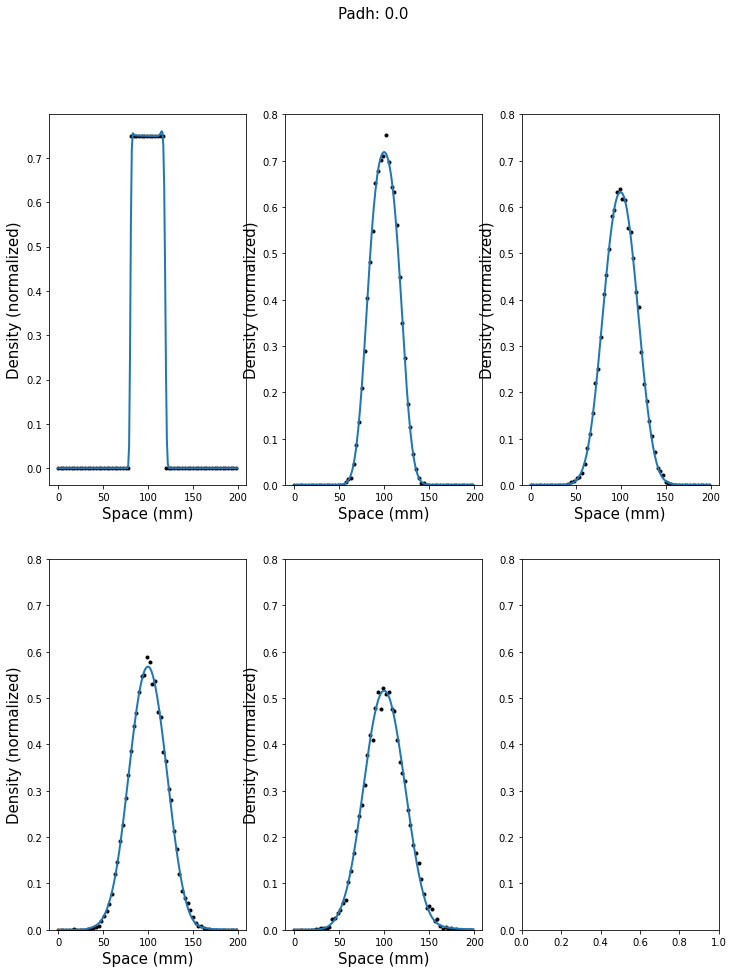

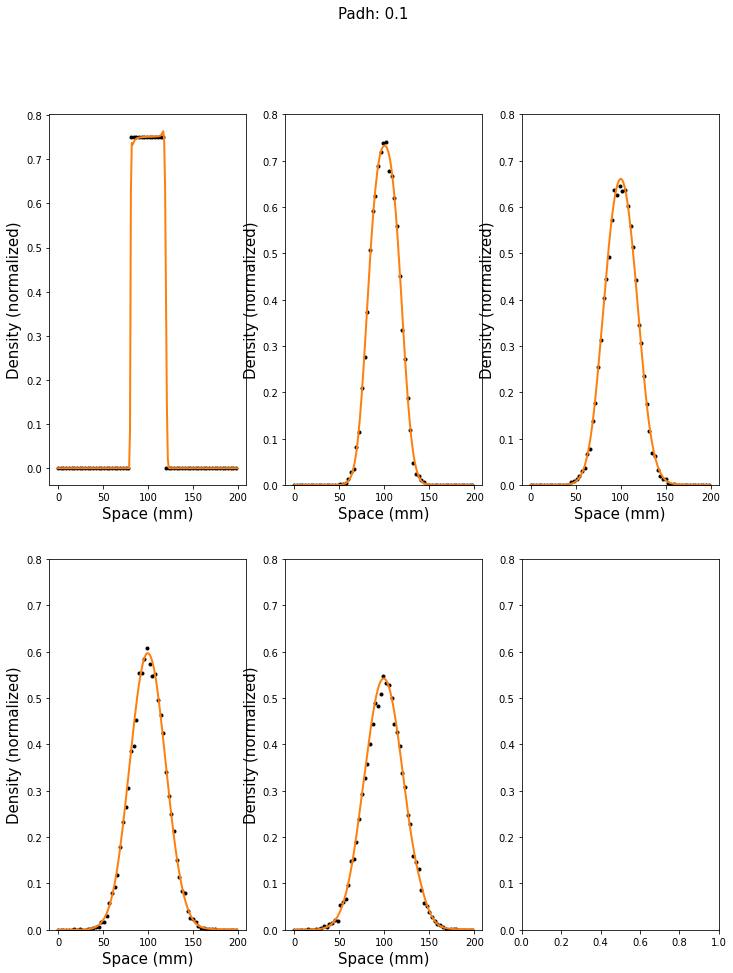

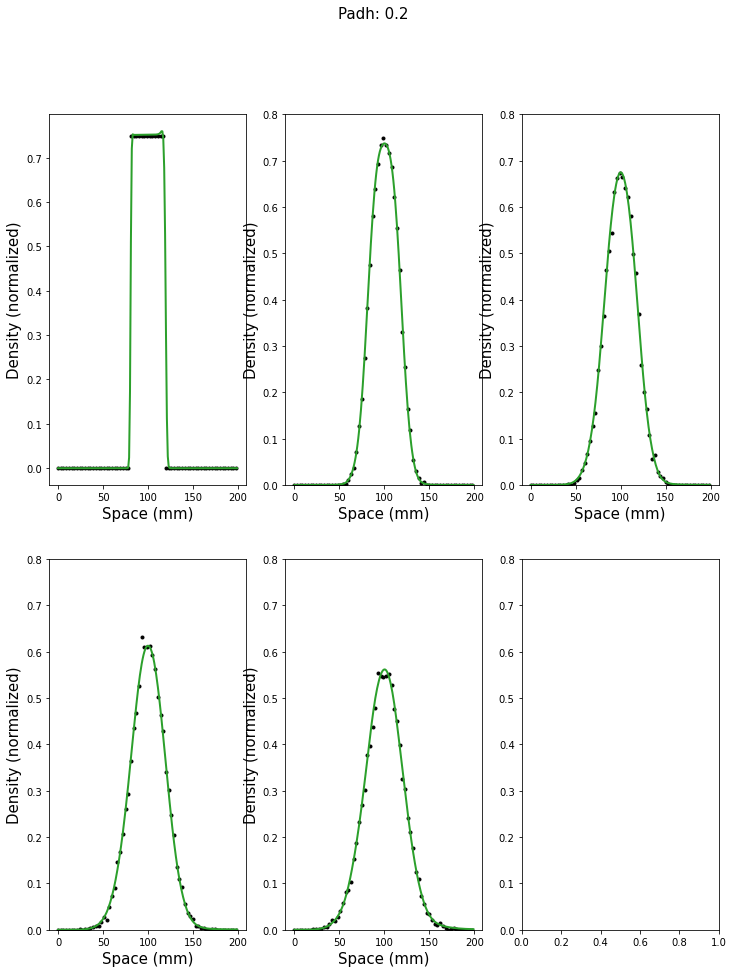

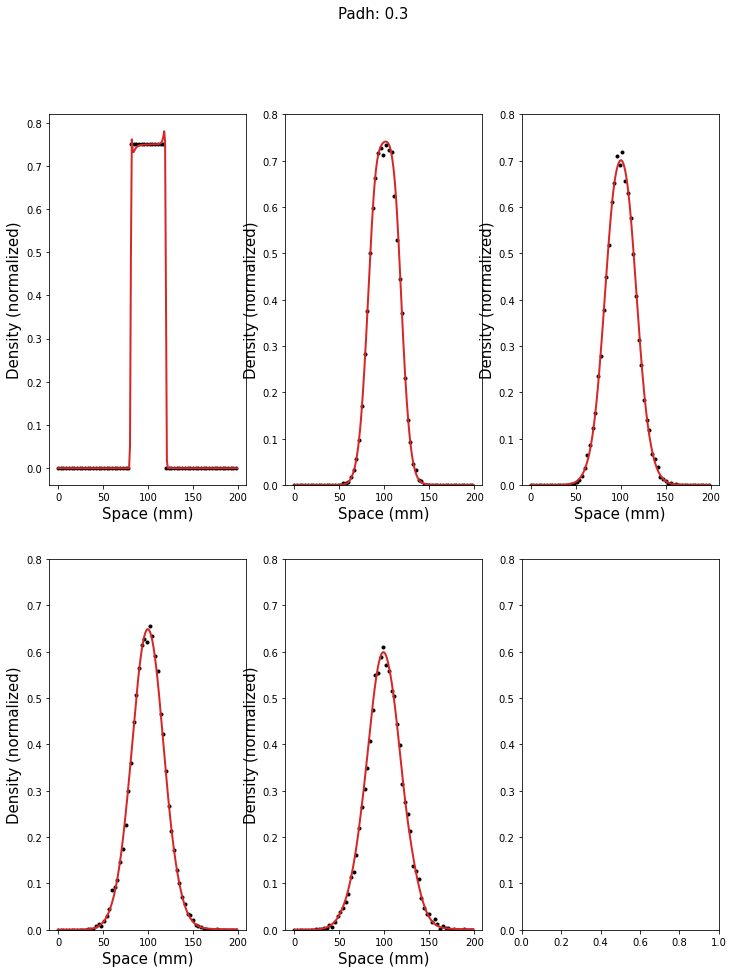

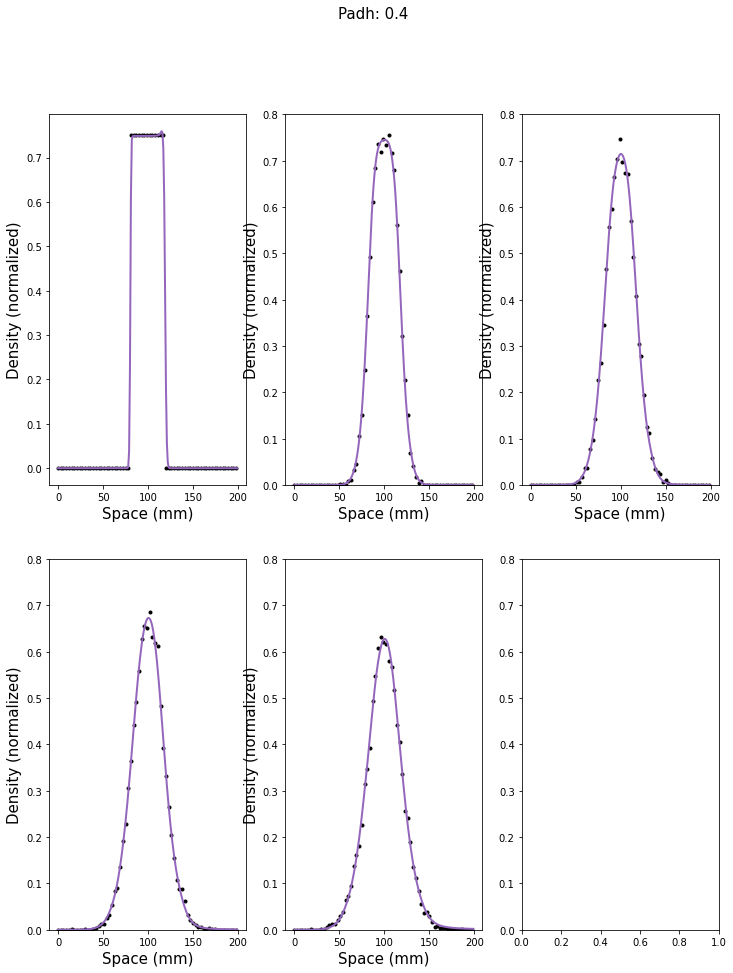

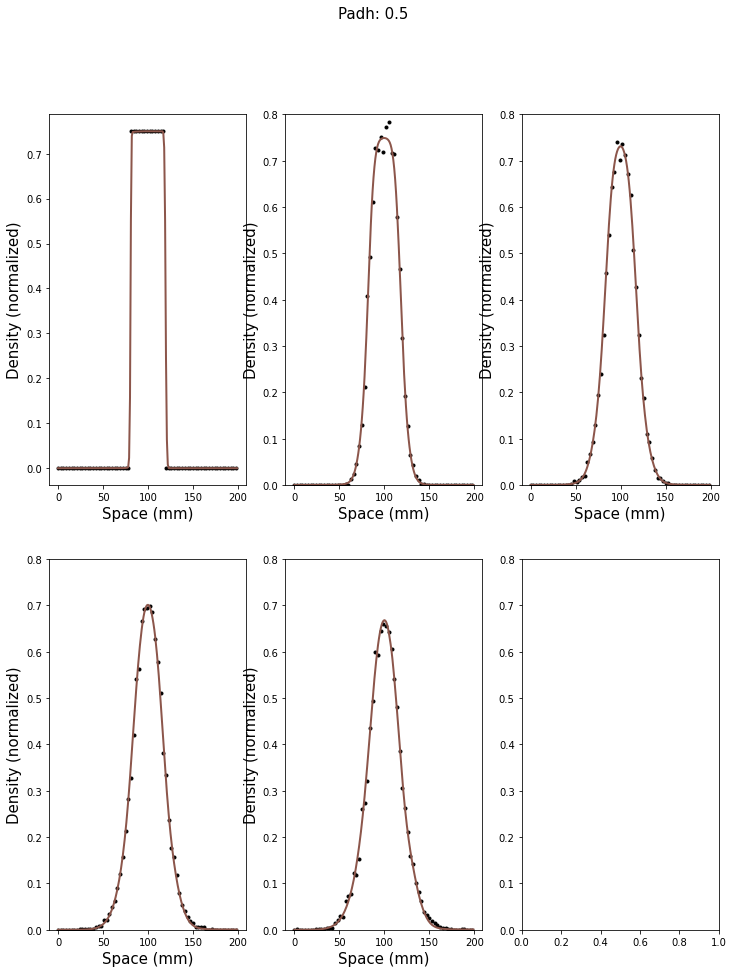

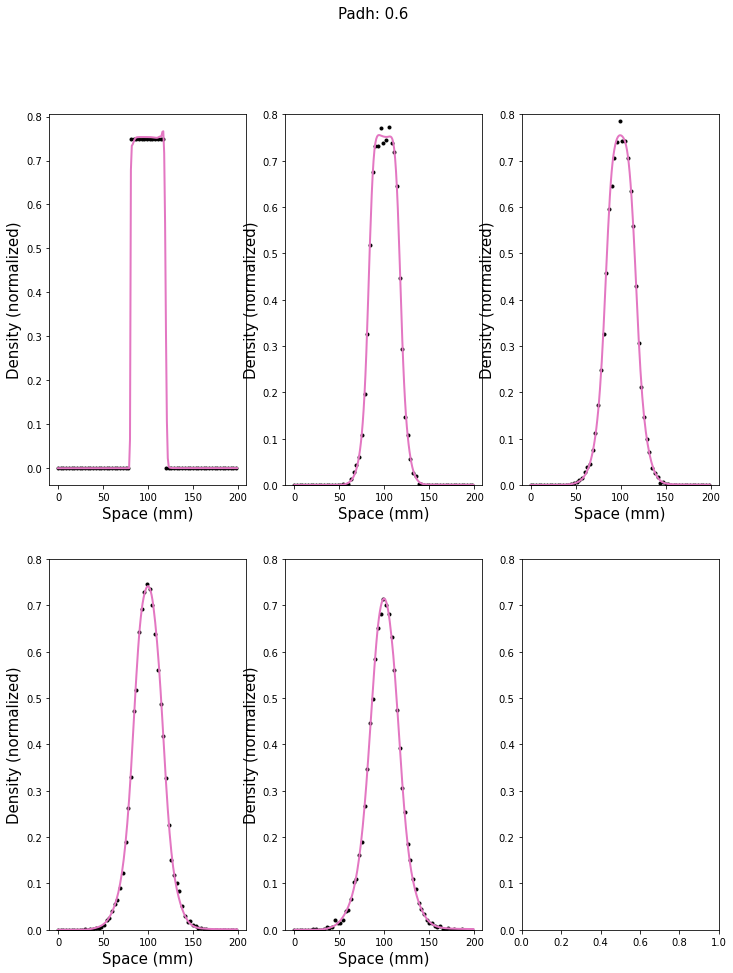

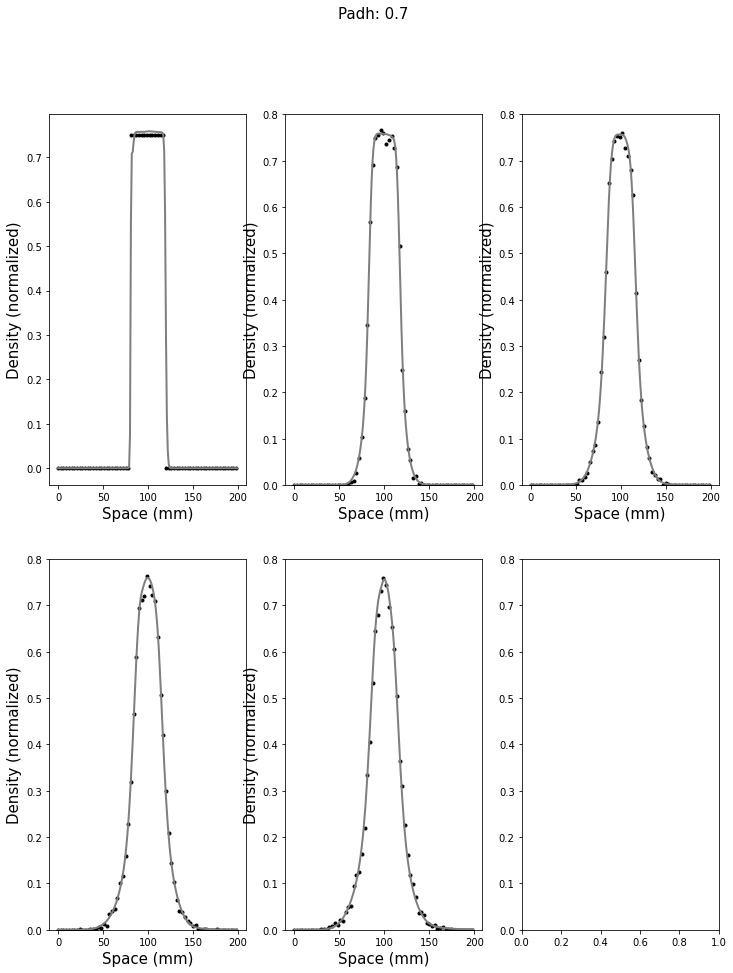

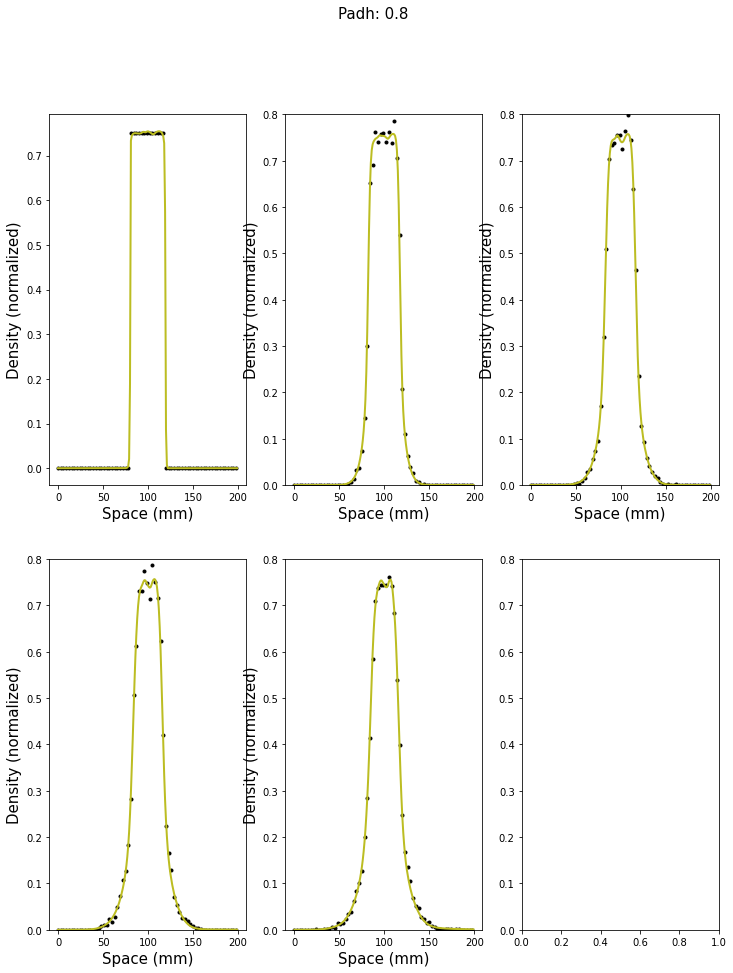

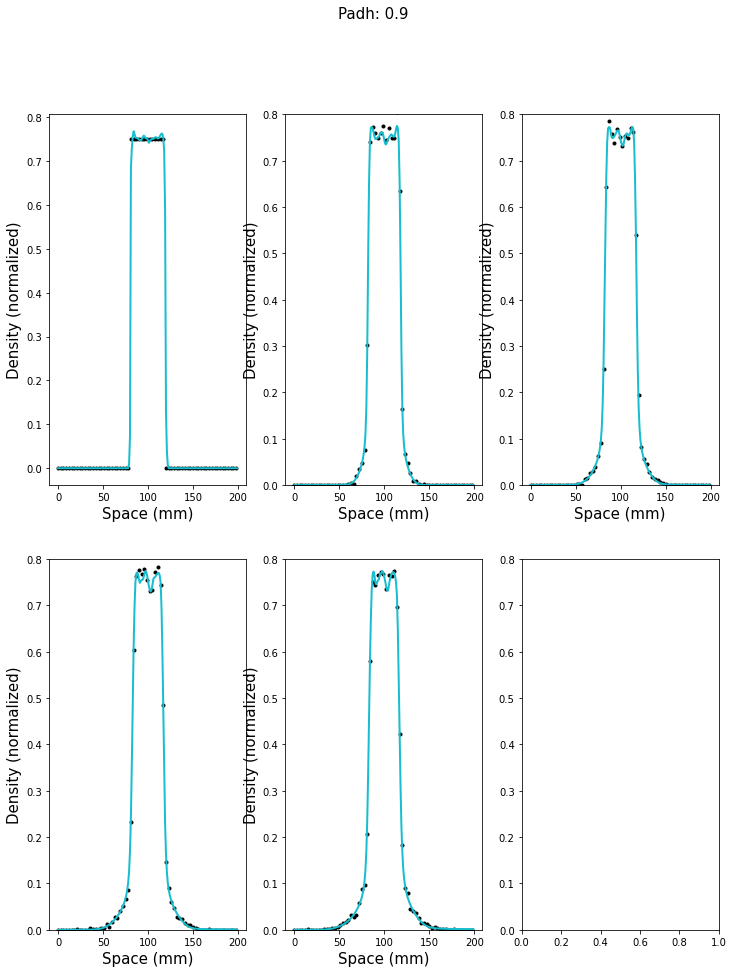

In [16]:
fontsize=15

for binn, inputs, outputs, color, param_combo in zip(binns,inputs_list,outputs_list,colors_plot, params):

    Pm, Pp, Pinteraction = param_combo
    
    #data
    X = inputs[:,0].reshape(shape)
    T = inputs[:,1].reshape(shape)
    x = np.unique(X)
    t = np.unique(T)
    U = outputs.reshape(shape)
    
    ### Generate BINN predictions
    binn_prediction = to_numpy(binn.surface_fitter(to_torch(inputs)))
    prediction = binn_prediction.reshape(shape)

    fig, axes = plt.subplots(2,3,figsize=(12,15))
    axes = axes.reshape(-1)

    count = 0
    for i in np.linspace(0,.75*len(t)-1,5,dtype=int):
        
        #axes[count].plot(prediction[::3,i],U[::3,i] - prediction[::3,i],"o",color="black",markersize=3)
        
        axes[count].plot(x[::3],U[::3,i],"o",color="black",markersize=3)
        axes[count].plot(x,prediction[:,i],"-",color=color,linewidth=2)

        axes[count].set_xlabel("Space (mm)",fontsize=fontsize)
        axes[count].set_ylabel("Density (normalized)",fontsize=fontsize)
        count+=1
        #axes[count].set_xlim([0,20])
        axes[count].set_ylim([0,.8])
        plt.suptitle(f"{suptitle}: {Pinteraction}",fontsize=fontsize)
        #ax.set_title(f"Replicate {i}",fontsize=fontsize)
    
    #axes[0].plot(prediction.reshape(-1),(U - prediction).reshape(-1),"o",color="black",markersize=3)


In [17]:
def unique_inputs(inputs):
    x = np.unique(inputs[:,0])
    t = np.unique(inputs[:,1])
    return x,t

def data_splitting(inputs,outputs,x,t,perc=0.75):
    
    tmax = np.max(t)

    #train on first 75% of timepoints
    training_index = inputs[:,1] <= perc*tmax
    testing_index  = inputs[:,1] >  perc*tmax
    
    inputs_training = inputs[training_index,:]
    outputs_training = outputs[training_index,:]
    inputs_testing = inputs[testing_index,:]
    outputs_testing = outputs[testing_index,:]

    t_train = np.unique(inputs_training[:,1])
    t_test = np.unique(inputs_testing[:,1])
    
    U_train = outputs_training.reshape((len(x),-1))
    U_test = outputs_testing.reshape((len(x),-1))
    
    return t_train, t_test, U_train, U_test

def DE_sim_train_test(x, t, q, IC, Diffusion_function):
    
    tmax = np.max(t)
    
    sol = odeint(Diffusion_eqn, IC, t, args=(x, q, Diffusion_function))
    sol = sol.T
    sol_train = sol[:,t<=.75*tmax]
    sol_test  = sol[:,t >.75*tmax]
    
    return sol_train, sol_test

def MSE(a,b):
    assert a.shape == b.shape
    return ((a - b)**2).mean()


def plot_DEs_against_data(x, t, U, sol, sol_binn, suptitle=None, filename=None):
    
    assert (len(x) == U.shape[0])
    assert (len(t) == U.shape[1])
    assert (U.shape == sol.shape) and (sol.shape == sol_binn.shape)
    
    fig, axes = plt.subplots(2,3,figsize=(8,10))
    axes = axes.reshape(-1)

    count = 0
    for i in np.linspace(0,len(t)-1,5,dtype=int):
        axes[count].plot(x[::10],U[::10,i],"o",color="black",markersize=7)
        axes[count].plot(x,sol[:,i],"-",linewidth=2)
        axes[count].plot(x,sol_binn[:,i],"--",linewidth=2)

        axes[count].set_xlabel("Space (mm)",fontsize=fontsize)
        axes[count].set_ylabel("Density (normalized)",fontsize=fontsize)
        count+=1
        ax.set_xlim([0,20])
        ax.set_ylim([0,0.9])
    
    if suptitle is not None:
        plt.suptitle(suptitle)
    if filename is not None:
        if filename[-4:] == ".pdf":
            plt.savefig(filename)
        else:
            plt.savefig(filename+".pdf")


MF:
[7.173224526052391e-05]
BINN:
[7.420367538870523e-05]

MF:
[9.41566097682774e-05]
BINN:
[9.587206369350545e-05]
MF:
[7.173224526052391e-05, 7.179732166636945e-05]
BINN:
[7.420367538870523e-05, 7.336136714763465e-05]

MF:
[9.41566097682774e-05, 9.385989156639336e-05]
BINN:
[9.587206369350545e-05, 0.00010067632784575897]
MF:
[7.173224526052391e-05, 7.179732166636945e-05, 7.044145595737548e-05]
BINN:
[7.420367538870523e-05, 7.336136714763465e-05, 7.199730462070691e-05]

MF:
[9.41566097682774e-05, 9.385989156639336e-05, 8.796515450243781e-05]
BINN:
[9.587206369350545e-05, 0.00010067632784575897, 9.556192313769486e-05]
MF:
[7.173224526052391e-05, 7.179732166636945e-05, 7.044145595737548e-05, 6.777264993471687e-05]
BINN:
[7.420367538870523e-05, 7.336136714763465e-05, 7.199730462070691e-05, 7.183001053847846e-05]

MF:
[9.41566097682774e-05, 9.385989156639336e-05, 8.796515450243781e-05, 8.688368496534565e-05]
BINN:
[9.587206369350545e-05, 0.00010067632784575897, 9.556192313769486e-05, 9.42

/tmp/ipykernel_294420/3649214772.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(2,3,figsize=(8,10))


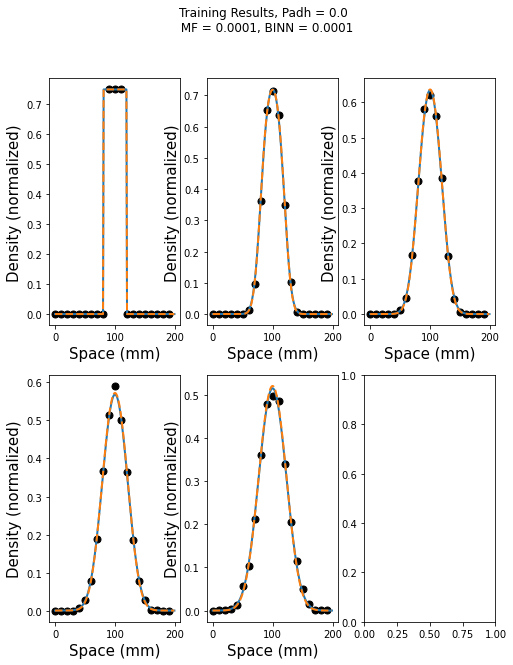

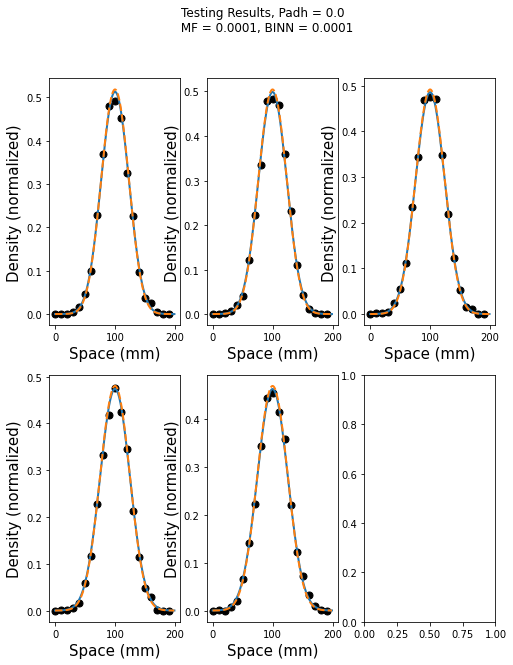

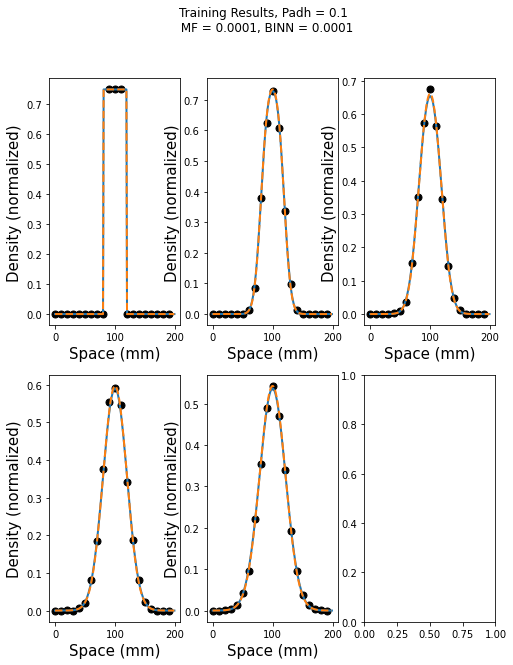

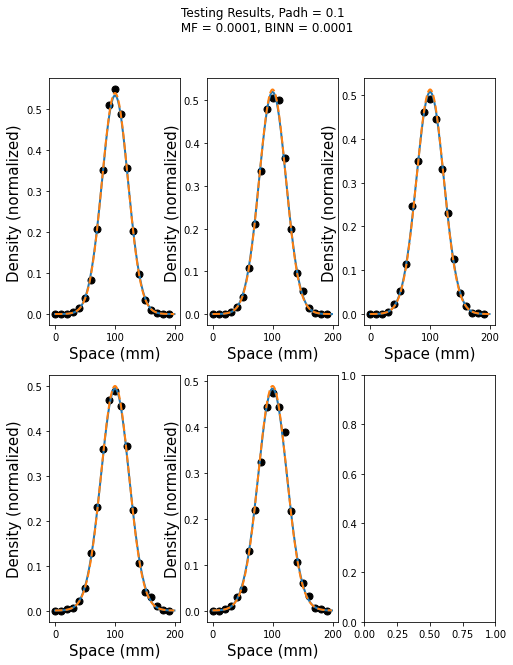

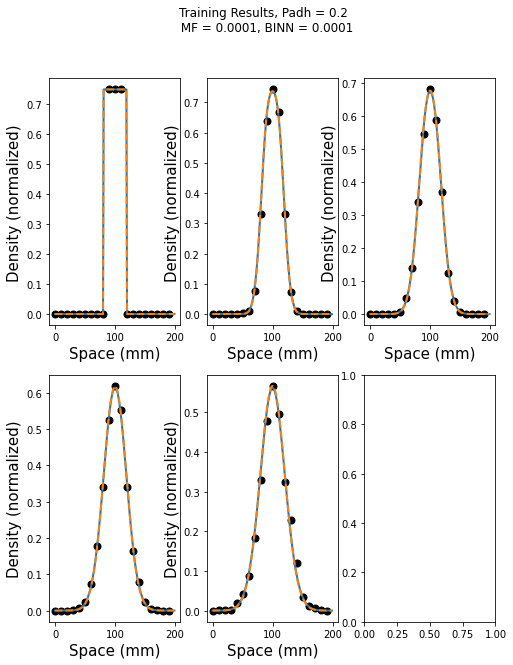

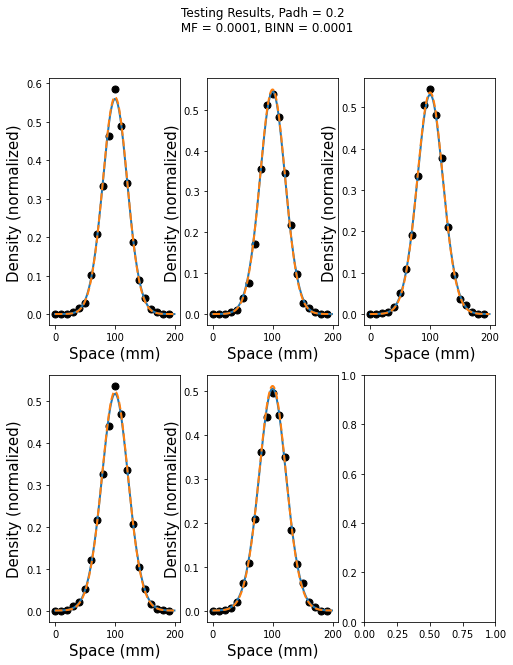

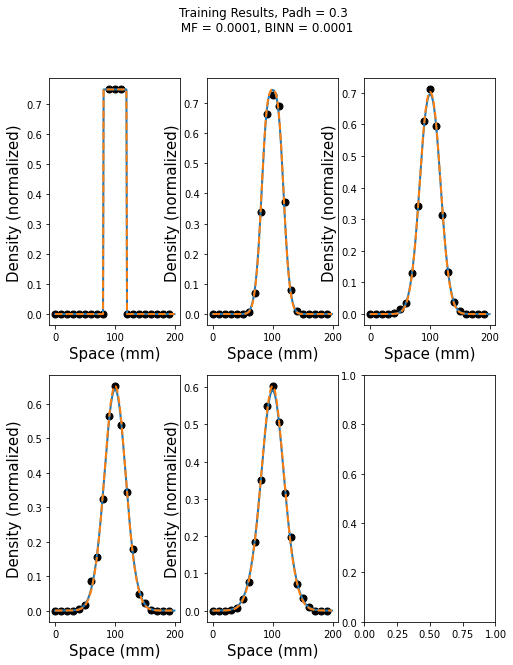

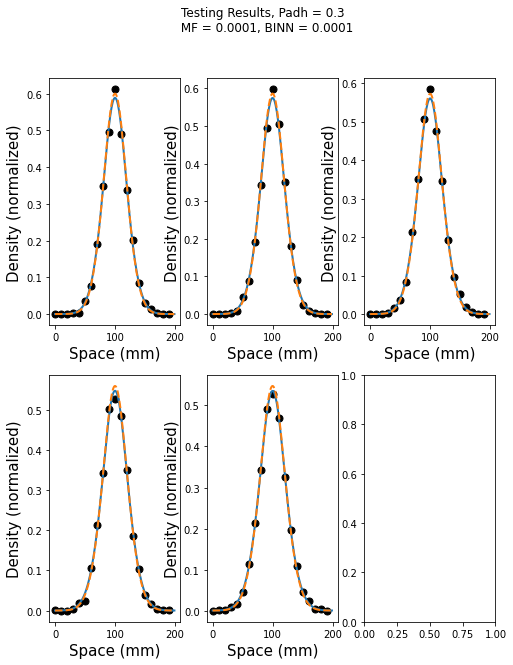

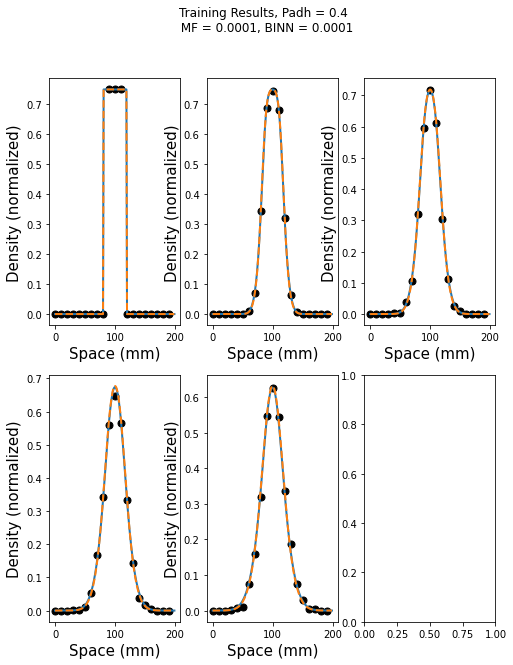

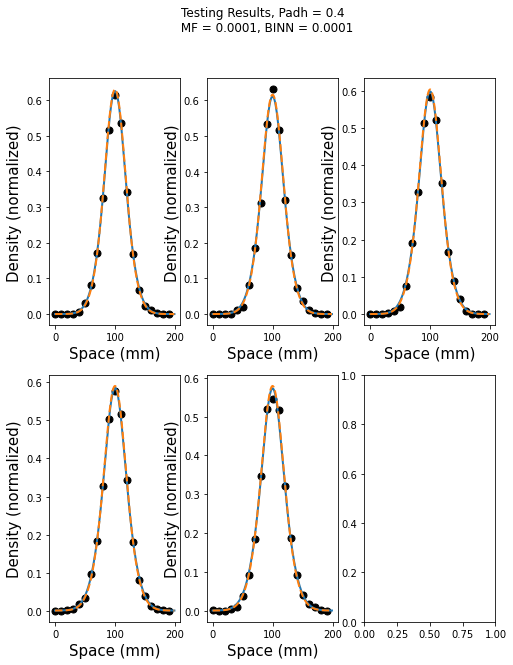

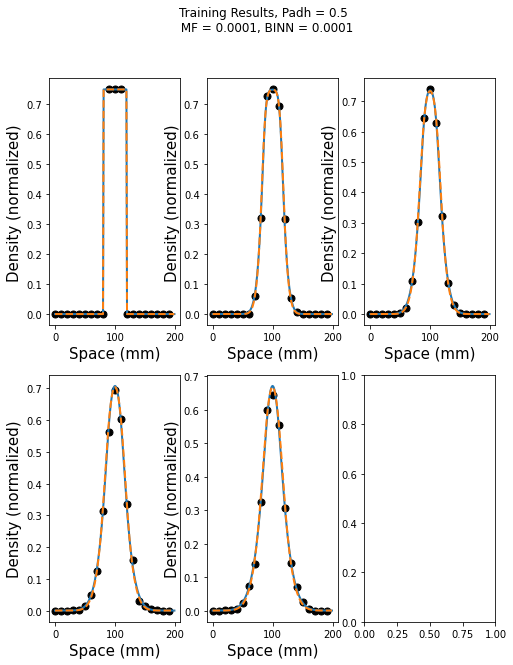

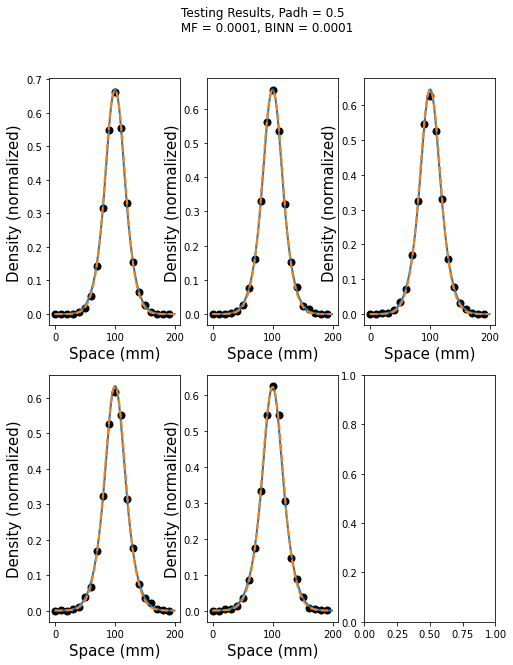

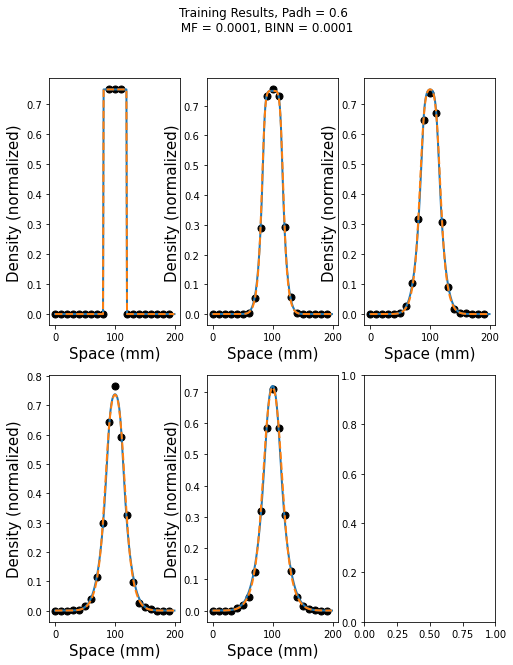

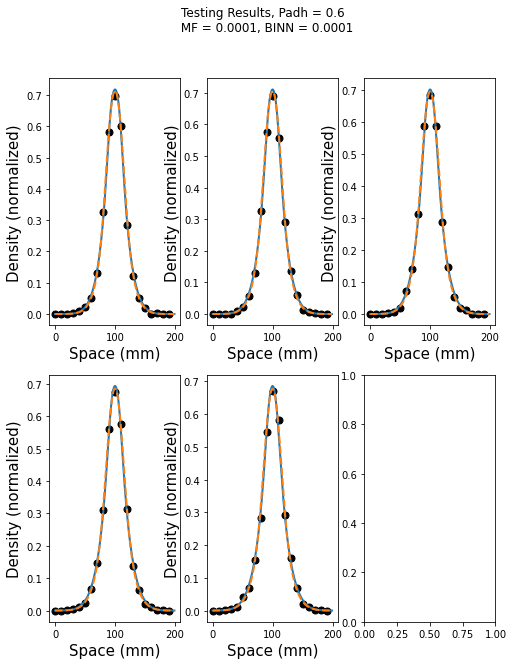

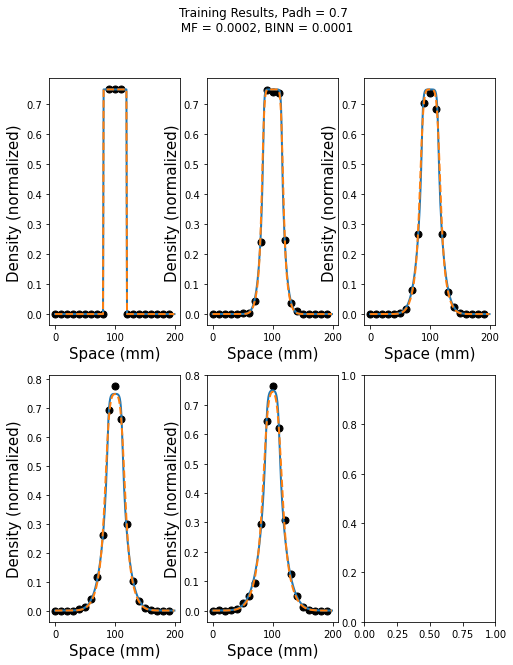

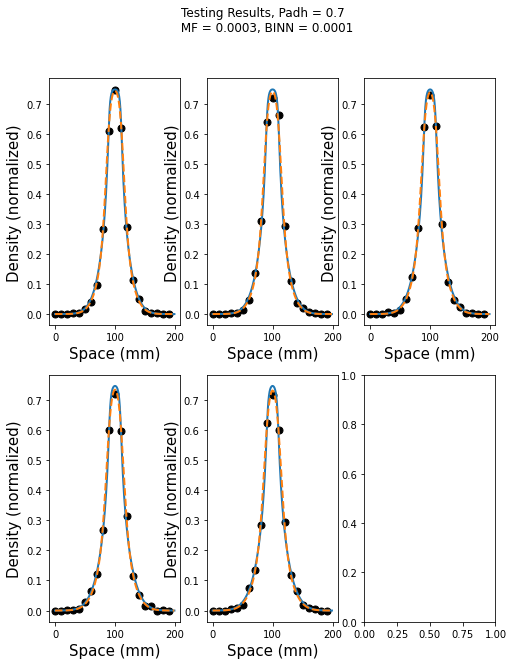

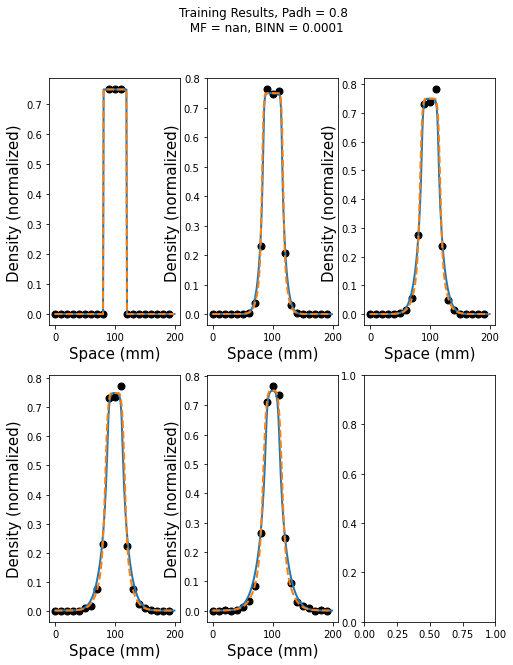

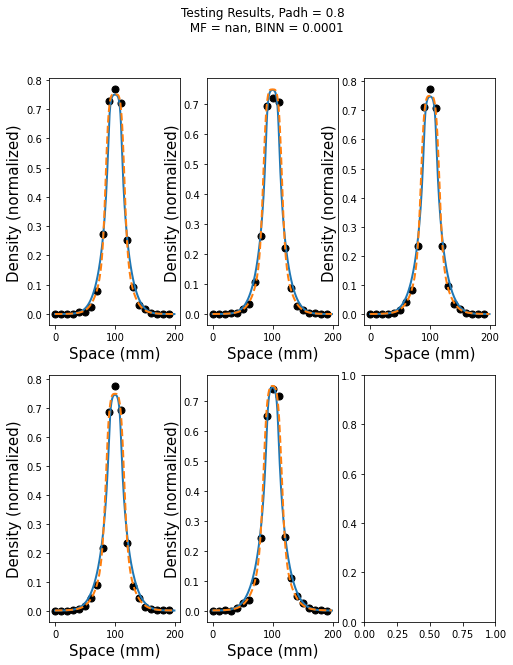

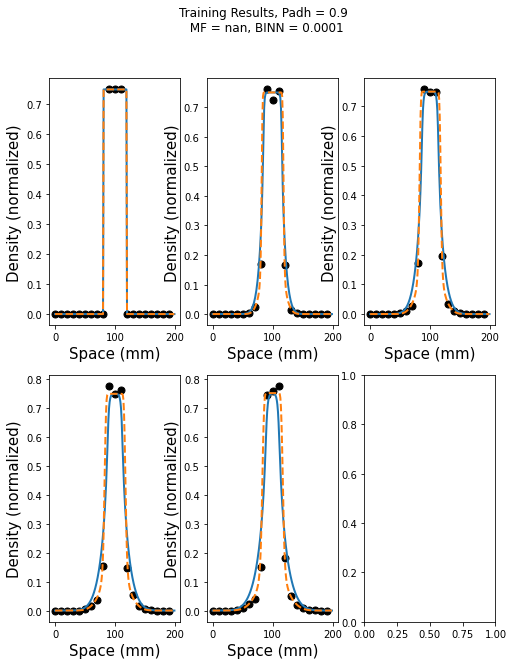

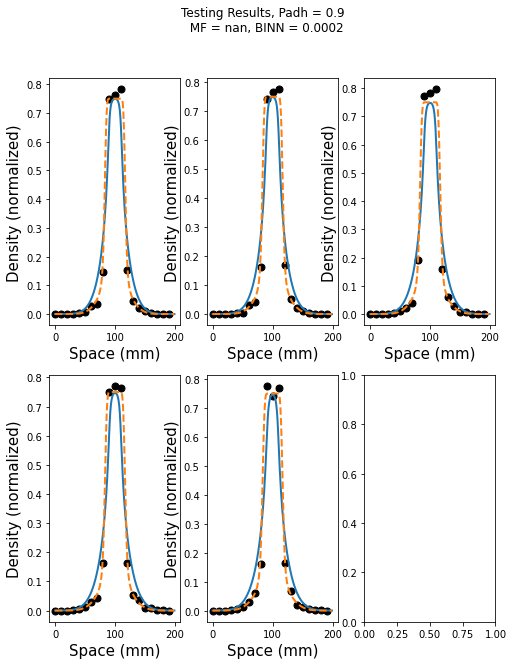

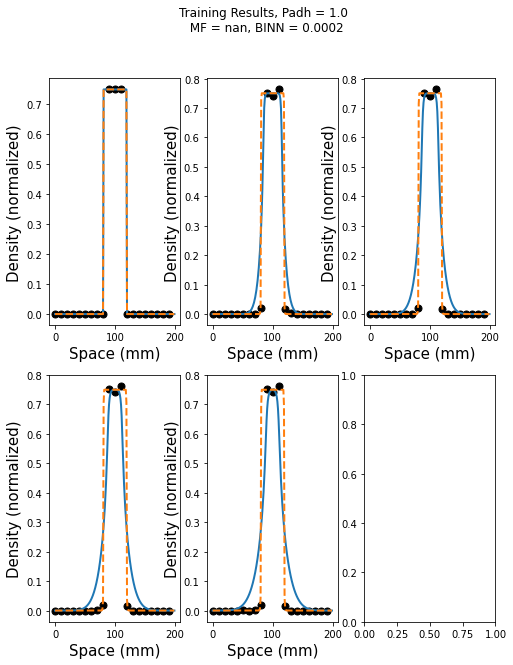

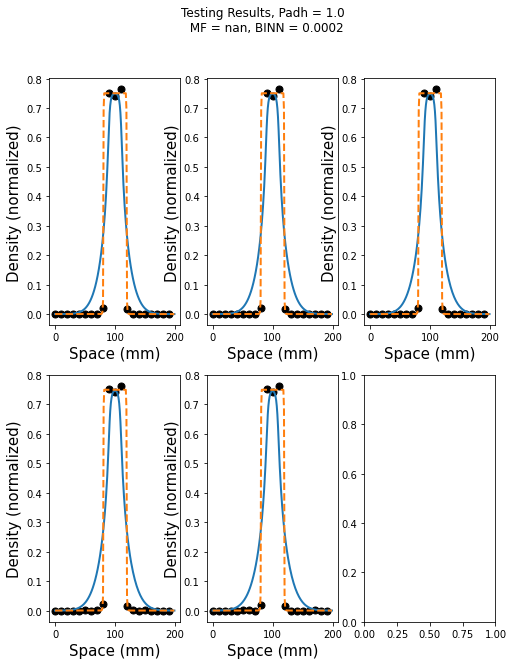

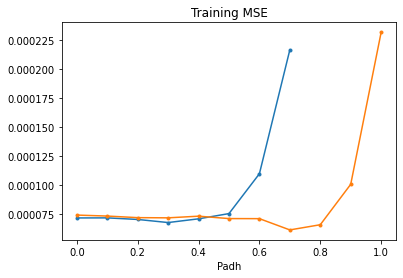

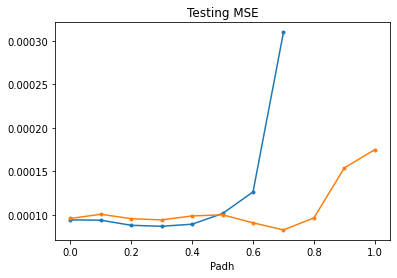

In [18]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['x','o','s','^','*','d']

MSE_MF_train = []
MSE_binn_train = []
MSE_MF_test = []
MSE_binn_test = []

for binn, inputs, outputs, param_combo in zip(binns,inputs_list,outputs_list,params):
    
    Pm, Pp, Pinteraction = param_combo
    
    x,t = unique_inputs(inputs)
    q = [Pm/4,Pinteraction]
    
    t_train, t_test, U_train, U_test = data_splitting(inputs,
                                                      outputs,
                                                      x,
                                                      t,
                                                      perc=0.75)

    IC = U_train[:,0]
    if ("Adhesion" in scenario) and (Pinteraction > 0.75):
        MF_MSE_train = np.nan
        MF_MSE_test = np.nan
        
    else:
        sol_train, sol_test = DE_sim_train_test(x, 
                                                t, 
                                                q, 
                                                IC, 
                                                Diffusion_function = diffusion)

        MF_MSE_train = MSE(sol_train, U_train)
        MF_MSE_test = MSE(sol_test, U_test)
    
    
    D_binn, G_binn = recover_binn_params(binn)
    sol_binn_train, sol_binn_test = DE_sim_train_test(x, 
                                            t, 
                                            q, 
                                            IC, 
                                            Diffusion_function = D_binn)
    
    BINN_MSE_train = MSE(sol_binn_train, U_train)
    BINN_MSE_test = MSE(sol_binn_test, U_test)
    
    MSE_MF_train.append(MF_MSE_train)
    MSE_binn_train.append(BINN_MSE_train)
    MSE_MF_test.append(MF_MSE_test)
    MSE_binn_test.append(BINN_MSE_test)
    
    print("MF:")
    print(MSE_MF_train)
    print("BINN:")
    print(MSE_binn_train)
    print("")
    print("MF:")
    print(MSE_MF_test)
    print("BINN:")
    print(MSE_binn_test)
    
    if "Pulling" in scenario:
        filename_DE_plot = f"BINN_MF_compare_Pm_{Pm}_Pp_{Pp}_Ppull_{Pinteraction}"
    elif "Adhesion" in scenario:
        filename_DE_plot = f"BINN_MF_compare_Pm_{Pm}_Pp_{Pp}_Padh_{Pinteraction}"    
    
    if "Pm" in scenario:
        param_vary_name = "Pm"
        Pvary = Pm
    elif "Ppull" in scenario:
        param_vary_name = "Ppull"
        Pvary = Pinteraction
    elif "Padh" in scenario:
        param_vary_name = "Padh"
        Pvary = Pinteraction
        
    plot_DEs_against_data(x, t_train, U_train, sol_train, sol_binn_train,
                         suptitle = f"Training Results, {param_vary_name} = {Pvary} \n MF = {np.round(MF_MSE_train,4)}, BINN = {np.round(BINN_MSE_train,4)}")
                         #filename = f"../../results/figures/training_{filename_DE_plot}.pdf")
    plot_DEs_against_data(x, t_test, U_test, sol_test, sol_binn_test,
                         suptitle = f"Testing Results, {param_vary_name} = {Pvary} \n MF = {np.round(MF_MSE_test,4)}, BINN = {np.round(BINN_MSE_test,4)}")
                         #filename = f"../../results/figures/testing_{filename_DE_plot}.pdf")
    
MSE_MF_train = np.array(MSE_MF_train)
MSE_MF_test = np.array(MSE_MF_test)
MSE_BINN_train = np.array(MSE_binn_train)
MSE_BINN_test = np.array(MSE_binn_test)

if "Pm" in scenario:
    Pvarys = Pms
elif "Ppull" in scenario:
    Pvarys = Ppulls
elif "Padh" in scenario:
    Pvarys = Padhs

plt.figure()
plt.plot(Pvarys, MSE_MF_train, ".-")
plt.plot(Pvarys, MSE_binn_train, ".-")
plt.title("Training MSE")
plt.xlabel(param_vary_name)
plt.savefig(f"../../results/figures/training_MSE_{filename_DE_plot}.pdf")

plt.figure()
plt.plot(Pvarys, MSE_MF_test, ".-")
plt.plot(Pvarys, MSE_binn_test, ".-")    
plt.title("Testing MSE")
plt.xlabel(param_vary_name)
plt.savefig(f"../../results/figures/testing_MSE_{filename_DE_plot}.pdf")

## Compare learned D and mean-field D over multiple params

In [8]:
print(MSE_MF_test)
print(MSE_binn_test)

[0.00046391 0.0004696 ]
[0.00046048309684511627, 0.000515672227630888]
